In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import KFold

import lime
from lime import lime_tabular

import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import seaborn as sn
import preprocess

In [2]:
data_type = 'caco'
feature_type = 'pubchem'

## Load data

In [3]:
exp_rf = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_rf.csv')
exp_hist = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_hist.csv')
exp_lgbm = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_lgbm.csv')
exp_xgboost = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_xgboost.csv')
exp_svr = pd.read_csv(f'../explanations/explanations_{data_type}_{feature_type}_svr.csv')

In [4]:
data_path = '../../data/processed/{}_{}_all.csv'.format(data_type, feature_type)
df = pd.read_csv(data_path)
X = df.loc[:, df.columns != df.columns[0]]
idxs = preprocess.remove_low_variance(X, threshold=0.01)

In [5]:
with open('../../pubchem_keys_dict.pickle', 'rb') as fp:
    Pubchem_keys_dict = pickle.load(fp)

In [6]:
def map_to_smarts(df):
    df_mapped = df + 1
    df_mapped = df_mapped.applymap(lambda x: Pubchem_keys_dict[x])
    return df_mapped

## Lime - aggregation by score 

In [7]:
def get_scores(explanations, len_data):
    scores = np.zeros(881)
    for index, exp in explanations.iterrows():
        num, score = int(exp['0']), exp['1']
        scores[num] += abs(score)
    scores /= len_data
    return scores

In [8]:
def get_top_k(explanations, k, len_data):
    scores = get_scores(explanations, len_data)
    top_f = np.argsort(abs(scores))[::-1]
    return top_f[:k]

In [9]:
k = 10
#df_top_5 = get_top_k(exp_rf, k, len(X))
len_data = 1000
top_10 = pd.DataFrame({'Random_forest': list(get_top_k(exp_rf, k, len_data)), 'Hist': list(get_top_k(exp_hist, k, len_data)), 'Lgbm': list(get_top_k(exp_lgbm, k, len_data)), 'Xgboost': list(get_top_k(exp_xgboost, k, len_data)), 'SVR': list(get_top_k(exp_svr, k, len_data))})
top_10

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,260,510,260,508,368
1,200,752,629,308,629
2,510,260,510,569,260
3,706,629,752,471,34
4,629,200,750,474,577
5,752,522,815,674,830
6,815,20,770,377,300
7,300,183,508,611,385
8,16,750,813,300,491
9,20,300,300,712,685


In [10]:
top_10_smarts = map_to_smarts(top_10)
top_10_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_agg_by_score.csv', index=False)
top_10_smarts

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,>= 3 hetero-aromatic rings,[#1]-N-N-[#1],>= 3 hetero-aromatic rings,S=C-N-C,C(~H)(~S)
1,>= 4 saturated or aromatic carbon-only ring si...,Clc1cc(Cl)ccc1,S-C:C:C-N,O-H,S-C:C:C-N
2,[#1]-N-N-[#1],>= 3 hetero-aromatic rings,[#1]-N-N-[#1],N-C-C-N,>= 3 hetero-aromatic rings
3,O=C-C-C-C-C(=O)-C,S-C:C:C-N,Clc1cc(Cl)ccc1,S:C:C:C,>= 2 S
4,S-C:C:C-N,>= 4 saturated or aromatic carbon-only ring si...,Nc1cc(Cl)ccc1,S:C:C:N,C:C-N-C:C
5,Clc1cc(Cl)ccc1,C-N-N-[#1],ClC1CC(Cl)CCC1,N-C-N-C:C,SC1C(N)CCCC1
6,ClC1CC(Cl)CCC1,>= 4 O,Nc1c(N)cccc1,C(~N)(:C)(:C),N-N
7,N-N,>= 1 unsaturated non-aromatic nitrogen-contain...,S=C-N-C,N-C-C-N-C,C(:C)(:C)(:C)
8,>= 4 N,Nc1cc(Cl)ccc1,NC1CC(Cl)CCC1,N-N,C-N:C-[#1]
9,>= 4 O,N-N,N-N,C-C(C)-C(C)-C,O=C-C-C-C-N


## Lime - aggregation by top k

In [11]:
def get_scores_top_k(explanations, k, len_data):
    scores = np.zeros(881)
    top_ks = [explanations[x:x+k] for x in range(0, len(explanations), len(idxs))]
    assert len(top_ks)==len_data
    for i in range(0,881):
        score = 0
        for top in top_ks:
            if i in list(top['0']): score +=1
        scores[i] = score
    scores /= len_data
    return scores

In [12]:
def get_top_k_top_k(explanations, k, len_data):
    scores = get_scores_top_k(explanations, k, len_data)
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [13]:
k = 10
topk_10 = pd.DataFrame({'Random_forest': list(get_top_k_top_k(exp_rf, k, len_data)), 'Hist': list(get_top_k_top_k(exp_hist, k, len_data)), 'Lgbm': list(get_top_k_top_k(exp_lgbm, k, len_data)), 'Xgboost': list(get_top_k_top_k(exp_xgboost, k, len_data)), 'SVR': list(get_top_k_top_k(exp_svr, k, len_data))})
topk_10

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,510,510,260,508,368
1,260,752,629,308,629
2,300,629,750,474,34
3,629,260,510,569,577
4,200,20,752,674,385
5,752,200,770,712,300
6,815,522,815,471,260
7,16,183,813,377,491
8,706,750,300,611,830
9,228,746,471,517,685


In [14]:
topk_10_smarts = map_to_smarts(topk_10)
topk_10_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_agg_by_topk.csv', index=False)
topk_10_smarts

,Random_forest,Hist,Lgbm,Xgboost,SVR
0,[#1]-N-N-[#1],[#1]-N-N-[#1],>= 3 hetero-aromatic rings,S=C-N-C,C(~H)(~S)
1,>= 3 hetero-aromatic rings,Clc1cc(Cl)ccc1,S-C:C:C-N,O-H,S-C:C:C-N
2,N-N,S-C:C:C-N,Nc1cc(Cl)ccc1,S:C:C:N,>= 2 S
3,S-C:C:C-N,>= 3 hetero-aromatic rings,[#1]-N-N-[#1],N-C-C-N,C:C-N-C:C
4,>= 4 saturated or aromatic carbon-only ring si...,>= 4 O,Clc1cc(Cl)ccc1,N-C-N-C:C,C(:C)(:C)(:C)
5,Clc1cc(Cl)ccc1,>= 4 saturated or aromatic carbon-only ring si...,Nc1c(N)cccc1,C-C(C)-C(C)-C,N-N
6,ClC1CC(Cl)CCC1,C-N-N-[#1],ClC1CC(Cl)CCC1,S:C:C:C,>= 3 hetero-aromatic rings
7,>= 4 N,>= 1 unsaturated non-aromatic nitrogen-contain...,NC1CC(Cl)CCC1,C(~N)(:C)(:C),C-N:C-[#1]
8,O=C-C-C-C-C(=O)-C,Nc1cc(Cl)ccc1,N-N,N-C-C-N-C,SC1C(N)CCCC1
9,>= 1 saturated or aromatic carbon-only ring si...,Sc1cc(N)ccc1,S:C:C:C,N-N-C-N,O=C-C-C-C-N


## Lime - comparison of models

In [15]:
def get_scores_top_k_example(explanations, k, len_data):
    top_ks = [explanations[x:x+k] for x in range(0, len(explanations), len(idxs))]
    assert len(top_ks)==len_data
    return top_ks

In [16]:
def get_top_k_2models_score(explanations_1, explanations_2, k, len_data):
    top_ks_1 = get_scores_top_k_example(explanations_1, k, len_data)
    top_ks_2 = get_scores_top_k_example(explanations_2, k, len_data)
    scores = []
    for j in range(0,881):
        for i in range(len(top_ks_1)):
            score = len(set(top_ks_1[i]['0']).intersection(top_ks_2[i]['0']))
            score /= k
            scores.append(score)
    return np.mean(scores)

In [17]:
get_top_k_2models_score(exp_rf, exp_hist, 10, len_data)

0.5313999999999999

In [18]:
'''
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
scores = []
for i, exp in enumerate(models_list):
    for exp2 in models_list[i+1:]:
        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))
print(scores)
'''

'\nmodels_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]\nscores = []\nfor i, exp in enumerate(models_list):\n    for exp2 in models_list[i+1:]:\n        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))\nprint(scores)\n'

In [19]:
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
scores = []
for i, exp in enumerate(models_list):
    for exp2 in models_list:
        scores.append(get_top_k_2models_score(exp, exp2, 10, len_data))
print(scores)

[1.0, 0.5313999999999999, 0.44799999999999984, 0.04709999999999998, 0.3204000000000001, 0.5313999999999999, 1.0, 0.35799999999999993, 0.04419999999999999, 0.23659999999999995, 0.44799999999999984, 0.35799999999999993, 1.0, 0.1294, 0.21499999999999986, 0.04709999999999998, 0.04419999999999999, 0.1294, 1.0, 0.06949999999999998, 0.3204000000000001, 0.23659999999999995, 0.21499999999999986, 0.06949999999999998, 1.0]


<AxesSubplot:>

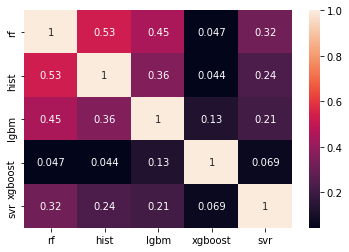

In [20]:
scores_arr = np.array(scores).reshape(5,5)
labels = ['rf', 'hist', 'lgbm', 'xgboost', 'svr']
heatmap_models = sn.heatmap(scores_arr, xticklabels=labels, yticklabels=labels, annot=True)
heatmap_models

In [21]:
fig = heatmap_models.get_figure()
fig.savefig(f"files/{data_type}/{data_type}_{feature_type}_models_heatmap.png") 

## Lime - comparison of models (features)

In [22]:
def get_top_k_2models(explanations_1, explanations_2, k, len_data):
    top_ks_1 = get_scores_top_k_example(explanations_1, k, len_data)
    top_ks_2 = get_scores_top_k_example(explanations_2, k, len_data)
    scores = np.zeros(881)
    for j in range(0,881):
        for i in range(len(top_ks_1)):
            common_fs = list(set(top_ks_1[i]['0']).intersection(top_ks_2[i]['0']))
            scores[common_fs] += 1
    scores /= len_data  
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [23]:
def get_top_k_more_models(explanations, k, len_data):
    top_ks = [get_scores_top_k_example(exp, k, len_data) for exp in explanations]
    scores = np.zeros(881)
    for j in range(0,881):
        for i in range(len(top_ks[0])):
            common_fs = list(set(top_ks[0][i]['0']).intersection(*[top[i]['0'] for top in top_ks]))
            scores[common_fs] += 1
    scores /= len_data  
    top_f = np.argsort(scores)[::-1]
    return top_f[:k]

In [24]:
#get_top_k_2models(exp_rf, exp_hist, 10, len_data)

In [25]:
models_list = [exp_rf, exp_hist, exp_lgbm, exp_xgboost, exp_svr]
labels = ['rf', 'hist', 'lgbm', 'xgboost', 'svr']
comp_models = pd.DataFrame()
for i, exp in enumerate(models_list):
    for j, exp2 in enumerate(models_list[i+1:]):
        column_name = labels[i] + '/' + labels[j+i+1]
        comp_models[column_name] = get_top_k_2models(exp, exp2, 10, len_data)
comp_models['all'] = get_top_k_more_models(models_list, 10, len_data)
comp_models

,rf/hist,rf/lgbm,rf/xgboost,rf/svr,hist/lgbm,hist/xgboost,hist/svr,lgbm/xgboost,lgbm/svr,xgboost/svr,all
0,510,629,16,629,510,522,629,471,629,577,300
1,752,260,300,300,629,183,260,508,260,300,288
2,629,510,471,260,260,474,300,16,300,34,299
3,260,752,522,510,752,300,510,517,510,368,298
4,200,815,880,20,200,471,34,308,34,308,297
5,300,300,290,767,750,645,20,300,308,508,296
6,16,200,299,830,770,16,830,34,508,880,295
7,20,16,298,298,721,308,279,880,299,290,294
8,706,706,297,297,300,34,278,291,298,298,293
9,227,471,296,296,706,298,299,298,297,297,292


In [26]:
comp_models_smarts = map_to_smarts(comp_models)
comp_models_smarts.to_csv(f'files/{data_type}/{data_type}_{feature_type}_models_comparison.csv', index=False)
comp_models_smarts

,rf/hist,rf/lgbm,rf/xgboost,rf/svr,hist/lgbm,hist/xgboost,hist/svr,lgbm/xgboost,lgbm/svr,xgboost/svr,all
0,[#1]-N-N-[#1],S-C:C:C-N,>= 4 N,S-C:C:C-N,[#1]-N-N-[#1],C-N-N-[#1],S-C:C:C-N,S:C:C:C,S-C:C:C-N,C:C-N-C:C,N-N
1,Clc1cc(Cl)ccc1,>= 3 hetero-aromatic rings,N-N,N-N,S-C:C:C-N,>= 1 unsaturated non-aromatic nitrogen-contain...,>= 3 hetero-aromatic rings,S=C-N-C,>= 3 hetero-aromatic rings,N-N,C-Na
2,S-C:C:C-N,[#1]-N-N-[#1],S:C:C:C,>= 3 hetero-aromatic rings,>= 3 hetero-aromatic rings,S:C:C:N,N-N,>= 4 N,N-N,>= 2 S,N-H
3,>= 3 hetero-aromatic rings,Clc1cc(Cl)ccc1,C-N-N-[#1],[#1]-N-N-[#1],Clc1cc(Cl)ccc1,N-N,[#1]-N-N-[#1],N-N-C-N,[#1]-N-N-[#1],C(~H)(~S),C-I
4,>= 4 saturated or aromatic carbon-only ring si...,ClC1CC(Cl)CCC1,BrC1C(Br)CCC1,>= 4 O,>= 4 saturated or aromatic carbon-only ring si...,S:C:C:C,>= 2 S,O-H,>= 2 S,O-H,C-Br
5,N-N,N-N,C-Al,Sc1c(N)cccc1,Nc1cc(Cl)ccc1,O=C-N-C-C,>= 4 O,N-N,O-H,S=C-N-C,C-Se
6,>= 4 N,>= 4 saturated or aromatic carbon-only ring si...,N-H,SC1C(N)CCCC1,Nc1c(N)cccc1,>= 4 N,SC1C(N)CCCC1,>= 2 S,S=C-N-C,BrC1C(Br)CCC1,C-As
7,>= 4 O,>= 4 N,C-I,C-I,Oc1ccc(N)cc1,O-H,B-P,BrC1C(Br)CCC1,N-H,C-Al,C-Cl
8,O=C-C-C-C-C(=O)-C,O=C-C-C-C-C(=O)-C,C-Br,C-Br,N-N,>= 2 S,B-Si,C-Si,C-I,C-I,C-S
9,>= 1 any ring size 8,S:C:C:C,C-Se,C-Se,O=C-C-C-C-C(=O)-C,C-I,N-H,C-I,C-Br,C-Br,C-P
